In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
cd ../src

/home/tviel/work/kaggle_rsna_lumbar_spine/src


In [33]:
import os
import cv2
import json
import glob
import torch
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import Counter
from tqdm.notebook import tqdm


pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

In [34]:
from params import *

from data.preparation import *

from data.dataset import *
from data.transforms import *

### Sagittal

In [35]:
from inference.lvl1 import Config
from util.plots import *
from data.sagital_to_axial import get_axial_coords

In [74]:
# EXP_FOLDER = "../logs/2024-08-12/22/"  # 20 ep
# EXP_FOLDER = "../logs/2024-08-12/26/"  # 30 ep
# EXP_FOLDER = "../logs/2024-08-12/27/"  # coatnet_rmlp_2_rw_384
# EXP_FOLDER = "../logs/2024-08-12/28/"  # coatnet_1
# EXP_FOLDER = "../logs/2024-08-12/29/"  # coatnet_rmlp_2_rw_384 lr =3e-4
# EXP_FOLDER = "../logs/2024-08-12/30/"  # coatnet_rmlp_2_rw_384 30ep

EXP_FOLDER = "../logs/2024-08-12/31/"  # coatnet_rmlp_2_rw_384 20 ep
EXP_FOLDER = "../logs/2024-08-12/32/"  # coatnet_rmlp_2_rw_384 30 ep

FOLD = 0

In [75]:
df = prepare_coords_data()

In [76]:
config = Config(json.load(open(EXP_FOLDER + "config.json", "r")))

folds = pd.read_csv(config.folds_file)
df = df.merge(folds, how="left")
df['fold'] = df['fold'].fillna(-1)

In [77]:
PLOT = True

  0%|          | 0/989 [00:00<?, ?it/s]

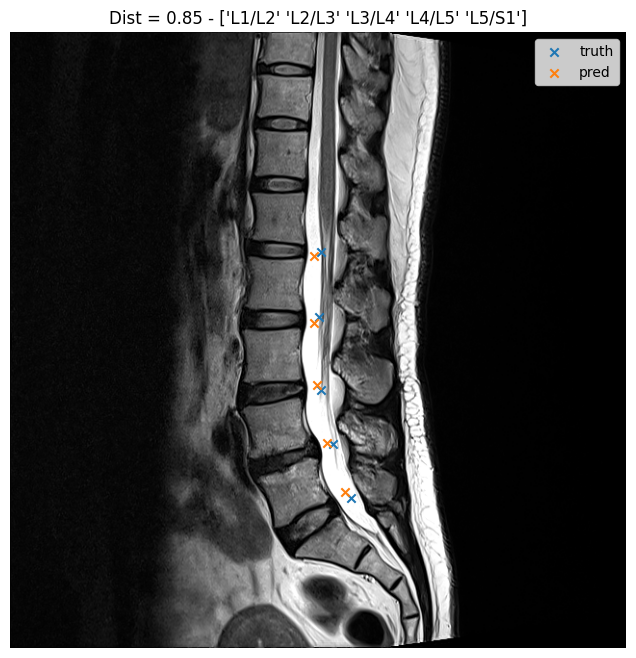

In [78]:
ds = []
df_ = prepare_data()

for fold in range(4):
    preds = np.load(EXP_FOLDER + f"pred_val_{fold}.npy")
    df_val = df[df['fold'] == fold].reset_index(drop=True)
    dataset = CoordsDataset(df_val, transforms=None)

    for idx in tqdm(range(len(dataset))):
        # if not df_val['study_id'][idx] in ref_studies:
        #     continue

        img, y, _ = dataset[idx]

        l = np.array(LEVELS)[np.where(y.numpy().sum(-1) > 0)[0]]

        # if len(l) != 5:
        #     print(l)
        # else:
        #     continue

        p = preds[idx].reshape(-1, 2)

        d = np.abs(p - y.numpy()) * 100
        d = d[y.sum(-1) > 0].mean()
        ds.append(d)

        # if d < 4:
        #     continue
        # print(df_val["series_id"][idx])

        if PLOT:
            y = y[y.sum(-1) > 0]

            plt.figure(figsize=(8, 8))
            plt.imshow(img)
            plt.scatter(y[:, 0] * img.shape[1], y[:, 1] * img.shape[0], marker="x", label="truth")
            plt.scatter(p[:, 0] * img.shape[1], p[:, 1] * img.shape[0], marker="x", label="pred")
            plt.title(f'Dist = {d:.2f} - {l}')
            plt.axis(False)
            plt.legend()
            plt.show()

            # if idx > 100:
            break
    # if PLOT:
    break


### Eval

In [79]:
print('Images with error > 5%:', (np.array(ds) > 5).sum())
print('Images with error > 4%:', (np.array(ds) > 4).sum())
print('Images with error > 3%:', (np.array(ds) > 3).sum())

Images with error > 5%: 0
Images with error > 4%: 0
Images with error > 3%: 0


In [80]:
# sns.histplot(ds)
# plt.axvline(np.mean(ds), c="salmon")
# plt.text(np.mean(ds), 100, f"   mean={np.mean(ds):.3f}", color="salmon")
# plt.show()

## Axial

In [81]:
ref_studies = [
    # 113758629,
    # 13317052, 60612428, 74294498, 142991438, 
    # 168833126, 189360935, 58813022, 1115952008, 959290081,
    2388577668  # bugged
]

PLOT = True
SAVE = False

CROP = False

SAVE_FOLDER = "../input/crops_ax/"

os.makedirs(SAVE_FOLDER, exist_ok=True)

In [82]:
def center_crop(img, size=224):
    d = size // 2
    assert img.shape[-1] != 3

    if img.shape[-1] <= size or img.shape[-2] <= size:
        return img
        
    yc, xc = img.shape[-2] // 2, img.shape[-1] // 2
    x0, x1, y0, y1 = xc - d, xc + d, yc - d, yc + d
    return img[..., y0: y1, x0: y1].copy()

In [83]:
from model_zoo.models import define_model
from util.torch import load_model_weights

In [84]:
EXP_FOLDER_AX = "../logs/2024-08-26/3/"

config = Config(json.load(open(EXP_FOLDER_AX + "config.json", "r")))

models_ax = []
for fold in range(4):
    model = define_model(
        config.name,
        drop_rate=config.drop_rate,
        drop_path_rate=config.drop_path_rate,
        pooling=config.pooling,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        n_channels=config.n_channels,
        reduce_stride=config.reduce_stride,
        pretrained=False,
    )
    model = model.cuda().eval()

    weights = EXP_FOLDER_AX + f"{config.name}_{fold}.pt"
    model = load_model_weights(model, weights, verbose=config.local_rank == 0)
    models_ax.append(model)

    break


 -> Loading encoder weights from ../logs/2024-08-26/3/coatnet_1_rw_224_0.pt



In [85]:
df = prepare_coords_data()

folds = pd.read_csv(config.folds_file)
df = df.merge(folds, how="left")
df['fold'] = df['fold'].fillna(-1)

In [88]:
df_ = prepare_data()
df_coords = pd.read_csv(DATA_PATH + "train_label_coordinates.csv")

In [104]:
x.size()

torch.Size([3, 224, 224])

  0%|          | 0/989 [00:00<?, ?it/s]

[ 4 12 19 28 33]


,instance_number,x,y,pred
level,,,,
L1/L2,3.5,162.207610,159.930082,4
L2/L3,11.0,163.439886,157.930472,12
L3/L4,19.0,159.440668,156.854259,19
L4/L5,28.0,160.188530,157.462284,28
L5/S1,35.0,162.822125,161.614320,33


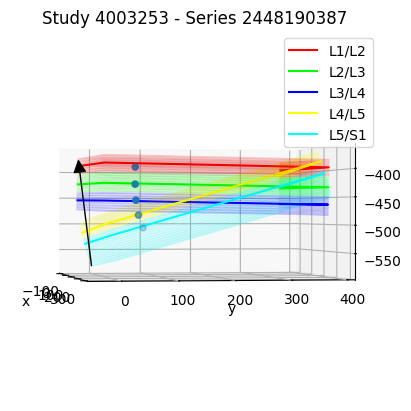

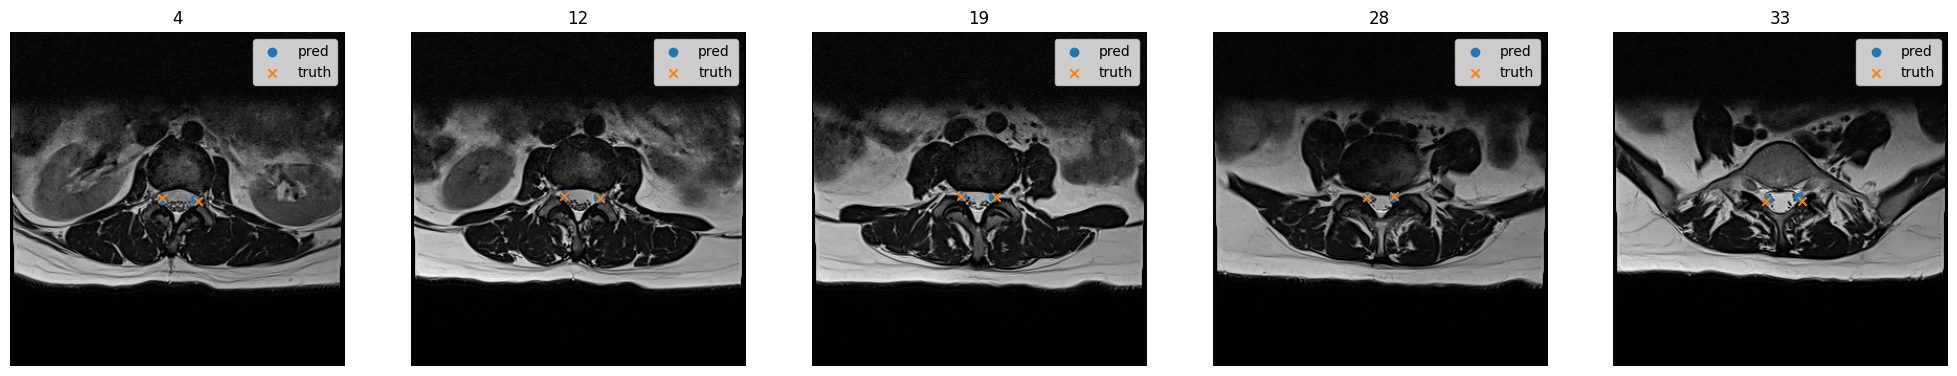

[ 2 10 17 27 33]


,instance_number,x,y,pred
level,,,,
L1/L2,3.5,162.207610,159.930082,2
L2/L3,11.0,163.439886,157.930472,10
L3/L4,19.0,159.440668,156.854259,17
L4/L5,28.0,160.188530,157.462284,27
L5/S1,35.0,162.822125,161.614320,33


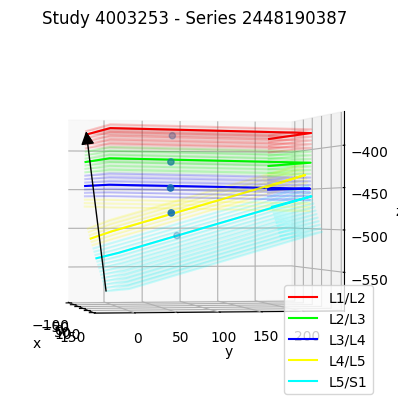

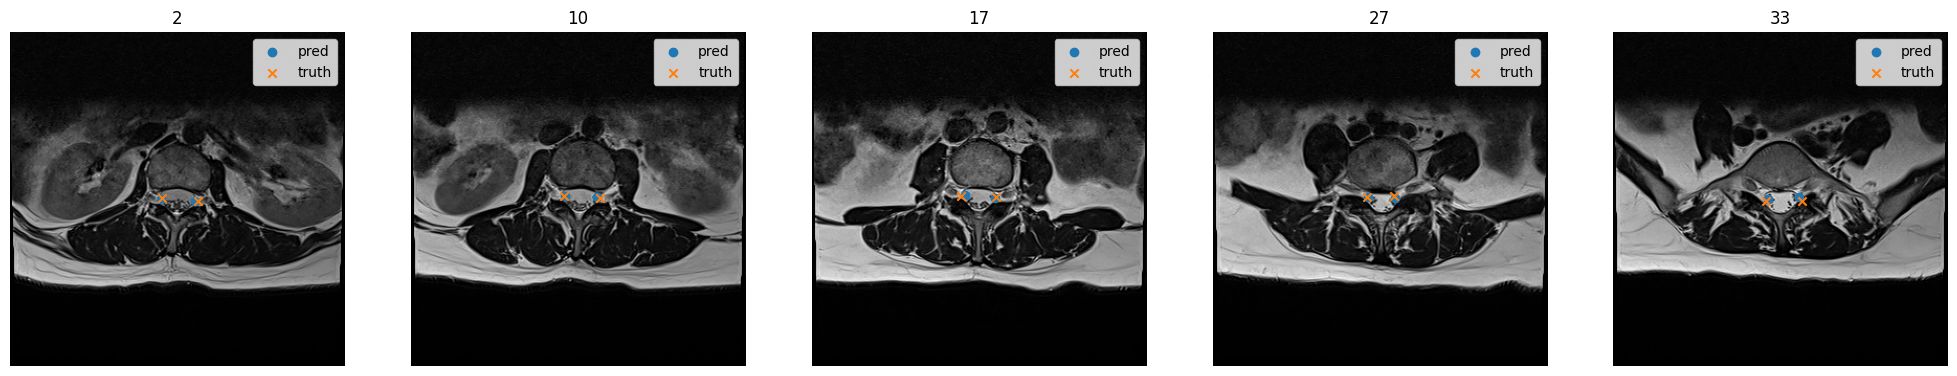

In [128]:
coords = []
axial_coords = []

for fold in range(4):
    preds_coords = np.load(EXP_FOLDER + f"pred_val_{fold}.npy")
    df_val = df[df["fold"] == fold].reset_index(drop=True)

    for idx in tqdm(range(len(df_val))):
        study = df_val["study_id"][idx]
        series = df_val["series_id"][idx]

        # if not study in ref_studies:
        #     continue

        p = preds_coords[idx].reshape(-1, 2)

        img = cv2.imread(df_val["img_path"][idx])
        h, w, _ = img.shape

        world_point, assigned_level, closest_z, df_axial = get_axial_coords(
            study,
            series,
            p.copy(),
            h,
            w,
            df_,
            "../input/train_images/",
        )

        if closest_z.max() == 0:  # Fix
            # print("fix")
            world_point[:, -1] -= (world_point[:, -1].mean() - df_axial.projection.mean())
            # print(world_point)
            # display(df_axial)
            world_point, assigned_level, closest_z, df_axial = get_axial_coords(
                study,
                series,
                p.copy(),
                h,
                w,
                df_,
                "../input/train_images/",
                world_point=world_point
            )

        series_ax = df_axial["series_id"].values[0]
        df_gt = df_coords[df_coords["series_id"] == series_ax].reset_index(drop=True)
        df_gt = df_gt[["instance_number", "level", "x", "y"]].groupby("level").mean().sort_index()

        gt = df_gt["instance_number"].values.flatten()
        preds = df_axial["instance_number"].values[closest_z]

        imgs = np.load(f'../input/npy2/{study}_{series_ax}.npy')
        
        if CROP:
            imgs = center_crop(imgs, 384)

        for i, lvl in enumerate(LEVELS_):
            axial_coords.append(
                {
                    "study": study,
                    "series": series,
                    "series": series_ax,
                    "level": lvl,
                    "closest_z": closest_z[i],
                    "clostest_instance": preds[i],
                }
            )

            if SAVE:
                frames = np.clip([closest_z[i] - 5, closest_z[i] + 5], 0, len(imgs))
                np.save(SAVE_FOLDER + f"{study}_{series_ax}_{lvl}.npy", imgs[frames[0]: frames[1]].copy())

        with torch.no_grad():
            x = torch.tensor(imgs[closest_z].astype(np.float32)).cuda()

            min_ = x.amin((-1, -2), keepdim=True)
            max_ = x.amax((-1, -2), keepdim=True)
            x = (x - min_) / (max_ - min_)
            x =  F.interpolate(
                x.unsqueeze(1).repeat(1, 3, 1, 1),
                config.resize,
                mode="bilinear",
            )

            preds_ax = models_ax[fold](x)[0].sigmoid().detach().cpu().numpy().reshape(x.size(0), 2, 2)

        preds_ax[:, :, 0] *= imgs.shape[2]
        preds_ax[:, :, 1] *= imgs.shape[1]

        print(preds)


        if PLOT:
            if len(df_gt) == 5:
                mae = np.abs(gt - preds).mean()
            else:
                continue
            if mae < 0:
                continue
            df_gt["pred"] = preds
            display(df_gt)

            plot_coords(
                world_point,
                assigned_level,
                closest_z,
                h,
                w,
                df_axial,
                title=f"Study {study} - Series {series_ax}",
            )
            df_lvl = df_coords[df_coords["series_id"] == series_ax].reset_index(drop=True)
            plt.figure(figsize=(25, 5))
            for i in range(5):
                plt.subplot(1, 5, i + 1)

                img = imgs[closest_z[i]]
                # img = np.clip(
                #     img,
                #     np.percentile(img.flatten(), 0),
                #     np.percentile(img.flatten(), 98),
                # )  # DO NOT FORGET
                # img = (img - img.min()) / (img.max() - img.min())

                if not CROP:
                    
                    df_lvl_ = df_lvl[df_lvl["level"] == LEVELS[i]]
                    x, y = df_lvl_['x'].values, df_lvl_["y"].values

                    plt.scatter(preds_ax[i, :, 0], preds_ax[i, :, 1], label="pred")
                    plt.scatter(x, y, label="truth", marker="x")

                plt.imshow(img, cmap="gray")
                plt.legend()
                plt.axis(False)
                plt.title(str(df_axial["instance_number"][closest_z[i]]))

            plt.show()
            if idx > 0:
                break
    # if PLOT:
    break

In [111]:
min_.size()

torch.Size([5, 320, 1])

In [ ]:
df_axial_coords = pd.DataFrame(axial_coords)
df_axial_coords = df_axial_coords.groupby(['study', 'series', 'level']).mean().reset_index()
df_axial_coords[['closest_z', "clostest_instance"]] = np.ceil(df_axial_coords[['closest_z', "clostest_instance"]]).astype(int)
display(df_axial_coords)

,study,series,level,closest_z,clostest_instance
0,4003253,2448190387,L1/L2,40,3
1,4003253,2448190387,L2/L3,32,11
2,4003253,2448190387,L3/L4,25,18
3,4003253,2448190387,L4/L5,16,28
4,4003253,2448190387,L5/S1,10,33
...,...,...,...,...,...
9865,4290709089,3390218084,L1/L2,22,1
9866,4290709089,3390218084,L2/L3,19,4
9867,4290709089,3390218084,L3/L4,15,9
9868,4290709089,3390218084,L4/L5,9,14


### Crop

In [ ]:
DELTA = 0.15

SAVE = True
PLOT = False

SAVE_FOLDER = f"../input/coords_crops_{DELTA}/"
os.makedirs(SAVE_FOLDER, exist_ok=True)

In [ ]:
ds = []

for fold in range(4):
    pred_val = np.load(EXP_FOLDER + f"pred_val_{fold}.npy")
    df_val = df[df['fold'] == fold].reset_index(drop=True)

    for idx in tqdm(range(len(df_val))):
        study_series = df_val["img_path"][idx].split('/')[-1][:-4]
        imgs_path = DATA_PATH + "npy/" + study_series + ".npy"
        imgs = np.load(imgs_path)

        preds = pred_val[idx].reshape(-1, 2)

        crops = np.concatenate([preds, preds], -1)
        crops[:, [0, 1]] -= DELTA
        crops[:, [2, 3]] += DELTA
        crops[:, [0, 2]] *= imgs.shape[2]
        crops[:, [1, 3]] *= imgs.shape[1]
        crops = crops.astype(int)

        preds[:, 0] *= imgs.shape[2]
        preds[:, 1] *= imgs.shape[1]

        # print(df_val["series_id"][idx])

        if SAVE:
            for i, (x0, y0, x1, y1) in enumerate(crops):
                crop = imgs[:, y0: y1, x0: x1].copy()
                np.save(SAVE_FOLDER + f'{study_series}_{LEVELS_[i]}.npy', crop)

                # cc = np.load(SAVE_FOLDER + study_series + "_" + LEVELS_[i] + ".npy")
                # plt.imshow(cc[len(cc) // 2], cmap="gray")
                # plt.show()

        if PLOT:
            plt.figure(figsize=(8, 8))
            plt.imshow(imgs[len(imgs) // 2], cmap="gray")
            plt.scatter(preds[:, 0], preds[:, 1], marker="x", label="pred")
            plt.scatter(crops[:, 0], crops[:, 1], marker="x", label="pred")
            plt.scatter(crops[:, 2], crops[:, 3], marker="x", label="pred")
            plt.title(study_series)
            plt.axis(False)
            plt.legend()
            plt.show()
            break

Done ! 